In [2]:
!pip install torch torchvision matplotlib scikit-learn seaborn

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

df = pd.read_csv("/content/merged_dataset.csv")

for col in ["Change %", "Open", 'High', 'Low']:
   if col in df.columns:
   	df.drop(columns=col, inplace=True)

df.dropna(inplace=True)

feature_scaler = RobustScaler()
target_scaler = RobustScaler()

feature_cols = df.columns.drop(['ir', 'DATE']) if 'DATE' in df.columns else df.columns.drop('ir')
X_df = df[feature_cols]
y_df = df[['ir']]

robust_df = df.copy()
robust_df[feature_cols] = feature_scaler.fit_transform(X_df)
robust_df['ir'] = target_scaler.fit_transform(y_df)

In [5]:
input_window = 30
output_window = 5

X_scaled = robust_df[feature_cols].values
y_scaled = robust_df[['ir']].values

X_seq, y_seq = [], []
for i in range(len(X_scaled) - input_window - output_window):
	X_seq.append(X_scaled[i:i+input_window])
	y_seq.append(y_scaled[i+input_window:i+input_window+output_window])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)


In [6]:
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size = 19, hidden_size=128, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)

    def forward(self, x):
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
  def __init__(self, hidden_size=128, output_size=1, num_layers=2):
    super().__init__()
    self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True,dropout=0.3)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x, hidden, cell):
    out, (hidden, cell) = self.lstm(x, (hidden, cell))
    out = self.dropout(out)
    return self.fc(out), hidden, cell

class Seq2Seq(nn.Module):
     def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

     def forward(self, src, target=None, target_len=5, force_ratio=0.5):
        batch_size = src.shape[0]
        hidden, cell = self.encoder(src)
        decoder_input = target[:, 0:1, :] if target is not None else src[:, -1:, 0:1]
        outputs = []

        for t in range(target_len):
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs.append(out)
            if target is not None and np.random.rand() < force_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = out
        return torch.cat(outputs, dim=1)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train.shape[2]
model = Seq2Seq(Encoder(input_size), Decoder()).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

num_epochs = 10
train_losses = []

model.train()
for epoch in range(num_epochs):
   total_loss = 0
   force_ratio = max(0.5 * (1 - epoch / num_epochs), 0.1)
   for X_batch, y_batch in train_loader:
       X_batch, y_batch = X_batch.to(device), y_batch.to(device)
       optimizer.zero_grad()
       output = model(X_batch, target=y_batch, target_len=output_window, force_ratio = force_ratio)
       loss = criterion(output, y_batch)
       loss.backward()
       optimizer.step()
       total_loss += loss.item()
   avg_loss = total_loss / len(train_loader)
   train_losses.append(avg_loss)
   scheduler.step(avg_loss)
   print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")







Epoch 1/10 - Loss: 0.168548
Epoch 2/10 - Loss: 0.020636
Epoch 3/10 - Loss: 0.017934
Epoch 4/10 - Loss: 0.015746
Epoch 5/10 - Loss: 0.016137
Epoch 6/10 - Loss: 0.014998
Epoch 7/10 - Loss: 0.014083
Epoch 8/10 - Loss: 0.013975
Epoch 9/10 - Loss: 0.012902
Epoch 10/10 - Loss: 0.012908


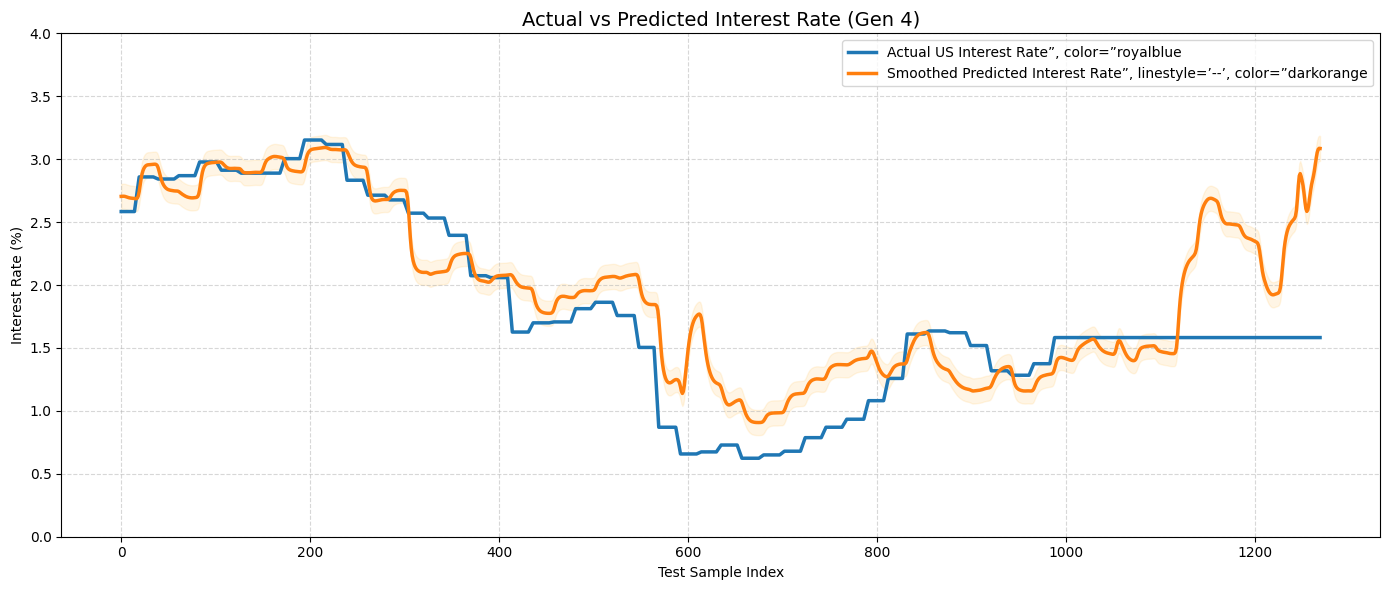

In [15]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
	for X_batch, y_batch in test_loader:
		X_batch = X_batch.to(device)
		output = model(X_batch, target_len=output_window)
		predictions.append(output.cpu().numpy())
		actuals.append(y_batch.numpy())

predictions = np.concatenate(predictions, axis=0).squeeze(-1)
actuals =  np.concatenate(actuals, axis=0).squeeze(-1)

pred_avg = predictions.mean(axis=1).reshape(-1, 1)
true_avg = actuals.mean(axis=1).reshape(-1, 1)

pred_ir = target_scaler.inverse_transform(pred_avg).flatten()
true_ir = target_scaler.inverse_transform(true_avg).flatten()

smooth_pred = pd.Series(pred_ir).rolling(window=9, win_type='gaussian', center=True, min_periods=1).mean(std=1.5)
pred_ir = np.clip(pred_ir, 0, 4)

plt.figure(figsize=(14, 6))
plt.plot(true_ir, label="Actual US Interest Rate”, color=”royalblue", linewidth=2.5)
plt.plot(smooth_pred, label="Smoothed Predicted Interest Rate”, linestyle=’--’, color=”darkorange", linewidth=2.5)
plt.fill_between(range(len(pred_ir)), smooth_pred - 0.1, smooth_pred + 0.1, color="orange", alpha= 0.1)
plt.title("Actual vs Predicted Interest Rate (Gen 4)",  fontsize=14)
plt.xlabel("Test Sample Index")
plt.ylabel("Interest Rate (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

MAE: 0.2898, RMSE: 0.4100, R2: 0.6940
Accuracy (±1.0%): 0.9591, F1 Score: 0.9791


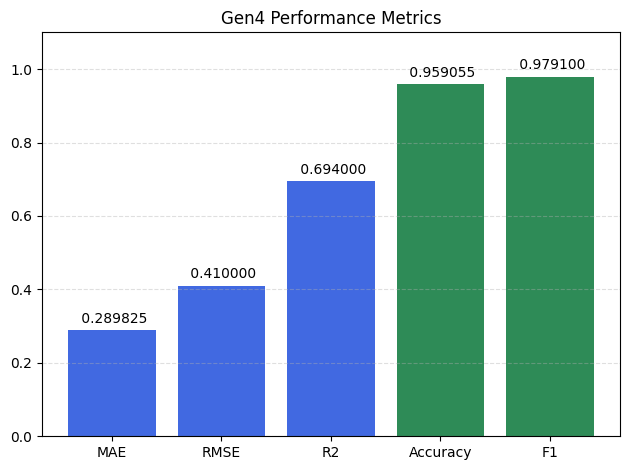

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

mae = mean_absolute_error(true_ir, pred_ir)
rmse = np.sqrt(mean_squared_error(true_ir, pred_ir))
r2 = r2_score(true_ir, pred_ir)
acc = accuracy_score(np.ones_like(true_ir), (np.abs(pred_ir - true_ir) <= 1.0).astype(int))
f1 = f1_score(np.ones_like(true_ir), (np.abs(pred_ir - true_ir) <= 1.0).astype(int))

print (f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print (f"Accuracy (±1.0%): {acc:.4f}, F1 Score: {f1:.4f}")

labels = ['MAE', 'RMSE', 'R2', 'Accuracy', 'F1']
scores = [mae, rmse, r2, acc, f1]

plt.bar(labels, scores, color=['royalblue']*3 + ['seagreen']*2)
plt.ylim(0, 1.1)
plt.title("Gen4 Performance Metrics")
for i, v in enumerate(scores):
	plt.text(i, v + 0.02, f"{v: 2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha = 0.4)
plt.tight_layout()
plt.savefig("gen4_metrics_summary.png")
plt.show()


In [20]:
import pickle
with open("seq2seq_us_ir_model.pkl", "wb") as f:
        pickle.dump(model, f)




In [21]:
with open("seq2seq_us_ir_model.pkl", "rb") as f:
       loaded_model = pickle.load(f)

loaded_model.eval()

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(19, 128, num_layers=2, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.3)
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

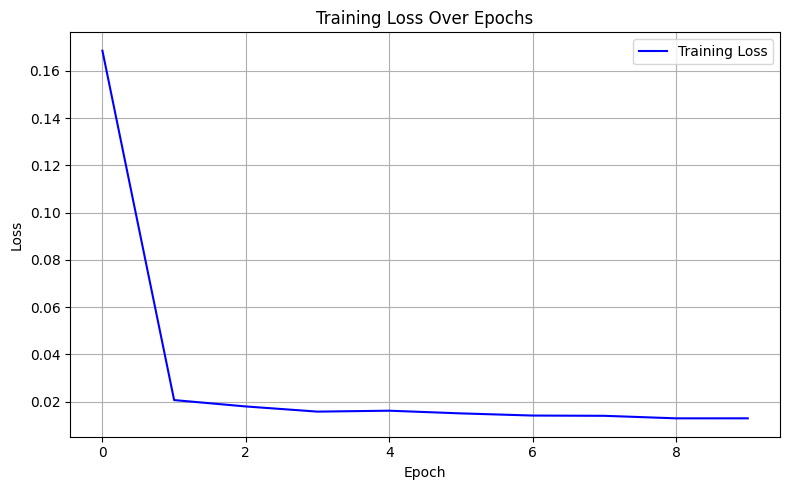

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("training_loss_curv.png")
plt.show()


In [27]:
torch.save(model.state_dict(), "seq2seq_Gen4_us_interest_rate_model.pth")
